# 영화 리뷰 감정 분석

In [1]:
# 일부만 할당된 GPU 메모리를 실행하는 동안 필요한만큼 늘릴 수 있도록 설정함
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [2]:
# 동일한 결과를 재현하기 위해서 random seed 고정
import numpy as np
np.random.seed(777)

In [3]:
from tensorflow.keras.datasets import imdb
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
np.load = np_load_old


In [4]:
sample_idx=4
print(train_data[sample_idx]) # 4번째 문장의 값

[1, 249, 1323, 7, 61, 113, 10, 10, 13, 1637, 14, 20, 56, 33, 2401, 18, 457, 88, 13, 2626, 1400, 45, 3171, 13, 70, 79, 49, 706, 919, 13, 16, 355, 340, 355, 1696, 96, 143, 4, 22, 32, 289, 7, 61, 369, 71, 2359, 5, 13, 16, 131, 2073, 249, 114, 249, 229, 249, 20, 13, 28, 126, 110, 13, 473, 8, 569, 61, 419, 56, 429, 6, 1513, 18, 35, 534, 95, 474, 570, 5, 25, 124, 138, 88, 12, 421, 1543, 52, 725, 6397, 61, 419, 11, 13, 1571, 15, 1543, 20, 11, 4, 2, 5, 296, 12, 3524, 5, 15, 421, 128, 74, 233, 334, 207, 126, 224, 12, 562, 298, 2167, 1272, 7, 2601, 5, 516, 988, 43, 8, 79, 120, 15, 595, 13, 784, 25, 3171, 18, 165, 170, 143, 19, 14, 5, 7224, 6, 226, 251, 7, 61, 113]


In [5]:
print(train_labels[sample_idx]) # 4번째 라벨의 값

0


In [21]:
word_index=imdb.get_word_index() # 단어와 인덱스를 매핑한 딕셔너리(제공되는 데이터임)
reverse_word_index = dict([(v,k) for (k,v) in word_index.items()]) # {단어: 정수} => {정수: 단어}로 

# 벡터화 된 문장을 텍스트로 디코딩
# 0, 1, 2번째 단어는 '패딩', '문서 시작', '사전에 없음'을 뜻하는 기호임.
# 그래서 각 문장에 매핑할 때는 이를 제외한 나머지 단어의 인덱스를 3 땡겨서 매핑함.
decoded_review = ' '.join([reverse_word_index.get(i-3,'?') for i in train_data[sample_idx]])
print(decoded_review)

? worst mistake of my life br br i picked this movie up at target for 5 because i figured hey it's sandler i can get some cheap laughs i was wrong completely wrong mid way through the film all three of my friends were asleep and i was still suffering worst plot worst script worst movie i have ever seen i wanted to hit my head up against a wall for an hour then i'd stop and you know why because it felt damn good upon bashing my head in i stuck that damn movie in the ? and watched it burn and that felt better than anything else i've ever done it took american psycho army of darkness and kill bill just to get over that crap i hate you sandler for actually going through with this and ruining a whole day of my life


In [36]:
len(reverse_word_index)

88584

In [37]:
print(train_data[13])

[1, 259, 37, 100, 169, 1653, 1107, 11, 14, 418, 7, 595, 3882, 8, 28, 68, 419, 8932, 75, 28, 4, 2, 8802, 5227, 173, 58, 7164, 322, 19, 2, 32, 120, 41, 648, 2, 1990, 39, 2448, 2, 34, 35, 4595, 492, 150, 59, 9, 2, 7143, 5170, 32, 120, 4, 3904, 1873, 4, 766, 38, 6204, 820, 6133, 8, 3177, 2, 9106, 41, 957, 11, 620, 1093, 75, 28, 4, 658, 37, 517, 46, 34, 2, 6, 4057, 37, 43, 571, 8, 30, 27, 577, 442, 3072, 19, 90, 88, 29, 385, 99, 946, 5, 630, 34, 5330, 27, 668, 7698, 260, 383, 19, 41, 3586, 5, 95, 2, 41, 56, 75, 28, 4, 554, 37, 9, 6866, 2, 34, 27, 8176, 5, 37, 266, 344, 5, 3936, 27, 1633, 25, 67, 45, 32, 2, 933, 3374, 4, 64, 542, 561, 11, 14, 3388, 2446, 7, 5174, 9, 54, 4, 1246, 1496, 27, 6256, 2, 45, 6, 52, 155, 14, 2803, 16, 324, 23, 374, 88, 900, 51, 6, 437, 7, 3269, 22, 12, 62, 30, 48, 15, 232, 37, 1291, 2719, 3882, 8, 30, 928, 11, 14, 2, 9, 66, 622, 57, 594, 91, 84, 104, 2719, 26, 2140, 75, 219, 14, 2320, 20, 95, 276, 23, 1456, 255, 4, 3612, 449, 61, 558, 12, 16, 6, 2, 17, 8, 63, 31, 16

In [62]:
a = {1: 'hi'}
a.get(0,'k')

'k'

# 2. 데이터 전처리

In [39]:
import numpy as np
# one-hot encoding
def vectorize_sequences(sequences, dimension=10000):
    # 행은 총 문장의 수, 열은 총 단어의 수
    results = np.zeros((len(sequences), dimension)) # (문장 수 x 단어수)
    
    # 문장별 단어의 존재 여부 표시하는 벡터
    # (인덱스, 값) --> 여기서는 (행,열) = 1
    for i, sequence in enumerate(sequences):
        results[i, sequence]= 1  # 문장에 존재하는 단어들만 one-hot encoding
    return results

# 문장을 일정한 크기의 벡터로 변환
# 1,0으로 된 벡터로 변환됨
X_train = vectorize_sequences(train_data)
X_test = vectorize_sequences(test_data)

In [40]:
# 리스트 형태인 레이블을 벡터로 변환
y_train = np.array(train_labels).astype('float32')
y_test = np.array(test_labels).astype('float32')

In [51]:
c=0
for i in range(len(train_data)):
    k= X_train[i][3]
    c+=k
print(c)

0.0


In [47]:
print(X_train.sum(axis=0))

[    0. 25000. 24325. ...    27.    31.    31.]


In [42]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(25000, 10000)
(25000,)
(25000, 10000)
(25000,)


In [59]:
# 검증셋과 훈려셋으로 나눔
# 데이터 나눔
X_valid = X_train[:10000]
X_train = X_train[10000:]
# 클래스 나눔
y_valid = y_train[:10000]
y_train = y_train[10000:]

# 3. 네트워크 정의

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(10000,))) # 속성 1만개
# 선형모델은 미분 연쇄로 해도 선형꼴로 나오기 때문에 비선형도 소화하는 relu 같은 함수를 쓰는 게 좋음
model.add(Dense(16, activation='relu')) # 두 번재 층부터는 알아서 속성 개수(가중치 수) 정해짐
model.add(Dense(1, activation='sigmoid'))


Instructions for updating:
Colocations handled automatically by placer.


# 4. 모델 컴파일

In [39]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# 5. 모델 학습

In [40]:
history = model.fit(X_train,y_train, epochs=20, batch_size=256, validation_data=(X_valid,y_valid))

Train on 15000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
15000/15000 [==============================] - 3s 222us/sample - loss: 0.4414 - acc: 0.8231 - val_loss: 0.3155 - val_acc: 0.8875
Epoch 2/20
15000/15000 [==============================] - 2s 153us/sample - loss: 0.2399 - acc: 0.9142 - val_loss: 0.2753 - val_acc: 0.8918
Epoch 3/20
15000/15000 [==============================] - 2s 145us/sample - loss: 0.1722 - acc: 0.9413 - val_loss: 0.2784 - val_acc: 0.8902
Epoch 4/20
15000/15000 [==============================] - 2s 144us/sample - loss: 0.1325 - acc: 0.9547 - val_loss: 0.3239 - val_acc: 0.8763
Epoch 5/20
15000/15000 [==============================] - 2s 148us/sample - loss: 0.1040 - acc: 0.9653 - val_loss: 0.3328 - val_acc: 0.8815
Epoch 6/20
15000/15000 [==============================] - 2s 144us/sample - loss: 0.0816 - acc: 0.9737 - val_loss: 0.3563 - val_acc: 0.8812
Epoch 7/20
15000/15000 [==============================] - 2s 1

# 6.학습과정 확인

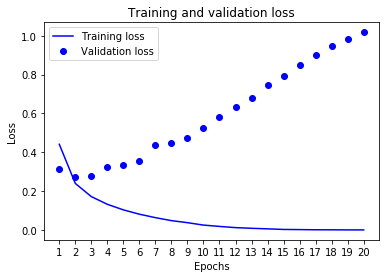

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

loss, val_loss = history.history['loss'], history.history['val_loss']
epochs= range(1,len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss') # b는 파란 실선 의미
plt.plot(epochs, val_loss, 'bo', label='Validation loss') # bo는 파란색 점을 의미
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()

plt.show()

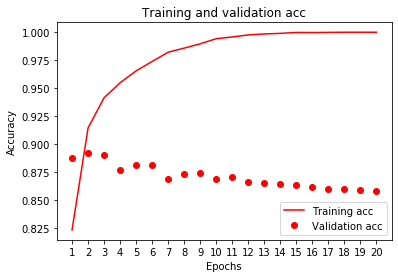

In [45]:
import matplotlib.pyplot as plt

acc,val_acc = history.history['acc'], history.history['val_acc']
plt.plot(epochs, acc, 'r', label="Training acc")
plt.plot(epochs, val_acc, 'ro', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()

plt.show()

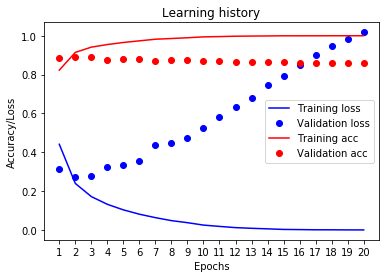

In [46]:
import matplotlib.pyplot as plt

loss, val_loss = history.history['loss'], history.history['val_loss']
acc, val_acc = history.history['acc'], history.history['val_acc']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'ro', label='Validation acc')
plt.title('Learning history')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.xticks(epochs)
plt.legend()

plt.show()

In [48]:
# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test loss(20 epochs): ', test_loss)
print('test acc(20 epochs): ', test_acc)

25000/25000 [==============================] - 4s 143us/sample - loss: 1.1174 - acc: 0.8464
test loss(20 epochs):  1.117377071764469
test acc(20 epochs):  0.8464


# 7. (과대적합 되기 전까지) 모델 학습

In [50]:
# 기존 model 객체를 사용하면 이어서 학습되므로, 새로운 model 객체를 생성함
model = Sequential()
model.add(Dense(16, activation='relu',input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
histroy = model.fit(X_train,y_train, validation_data=(X_valid,y_valid), 
                    epochs=3, batch_size=256)


Train on 15000 samples, validate on 10000 samples
Epoch 1/3
15000/15000 [==============================] - 2s 162us/sample - loss: 0.4525 - acc: 0.8170 - val_loss: 0.3307 - val_acc: 0.8803
Epoch 2/3
15000/15000 [==============================] - 2s 141us/sample - loss: 0.2509 - acc: 0.9139 - val_loss: 0.2749 - val_acc: 0.8916
Epoch 3/3
15000/15000 [==============================] - 2s 141us/sample - loss: 0.1812 - acc: 0.9371 - val_loss: 0.2962 - val_acc: 0.8820


In [51]:
test_loss, test_acc = model.evaluate(X_test,y_test) # 테스트셋을 통해 loss, acc 반환
print('test loss(3 epochs): ', test_loss)
print('test acc(3 epochs): ', test_acc)

25000/25000 [==============================] - 3s 135us/sample - loss: 0.3220 - acc: 0.8702
test loss(3 epochs):  0.32201901911735537
test acc(3 epochs):  0.87016


In [53]:
# 여러 개 동시에 예측
result = model.predict(X_test)
print(result)

print()

# 하나씩 예측
sample = X_test[0]
result = model.predict(np.expand_dims(sample, axis=0))
print(result)

[[0.17136142]
 [0.99846053]
 [0.77086294]
 ...
 [0.04384962]
 [0.0578194 ]
 [0.30276757]]

[[0.1713615]]


# 로이터 뉴스 카테고리 분류

In [69]:
# 동일한 결과를 재현하기 위해서 random seed 고정
import numpy as np
np.random.seed(777)

## 1. 데이터 준비 

In [70]:
from tensorflow.keras.datasets import reuters
import numpy as np

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

# restore np.load for future normal usage
np.load = np_load_old

In [71]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(v,k) for (k,v) in word_index.items()])
# 0, 1, 2는 '패딩', '문서 시작', '사전에 없음'을 위한 인덱스이므로 3을 뺍니다
decoded_newswire = ' '.join([reverse_word_index.get(i-3,'?') for i in train_data[0]])

In [72]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

## 2. 데이터 전처리

In [73]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results =np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences): # (인덱스, 값) 형태로 차례로 나옴
        results[i,sequence] = 1.
    return results
    
# 훈련 데이터 벡터 변환
x_train = vectorize_sequences(train_data)
# 테스트 데이터 벡터 변환
x_test = vectorize_sequences(test_data)    

In [55]:
from keras.utils.np_utils import to_categorical

# 각 라벨을 원핫인코딩 형식으로 변환
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [56]:
one_hot_train_labels[0]

array([0., 1.], dtype=float32)

In [57]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

## 3. 네트워크 정의

In [80]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

## 4. 모델 컴파일

In [81]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 5. 모델 학습

In [83]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, 
                    validation_data=(x_val,y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 289us/step - loss: 2.5322 - acc: 0.4955 - val_loss: 1.7208 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 1s 96us/step - loss: 1.4452 - acc: 0.6879 - val_loss: 1.3459 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 1s 94us/step - loss: 1.0953 - acc: 0.7651 - val_loss: 1.1708 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 1s 98us/step - loss: 0.8697 - acc: 0.8165 - val_loss: 1.0793 - val_acc: 0.7590
Epoch 5/20
7982/7982 [==============================] - 1s 96us/step - loss: 0.7034 - acc: 0.8472 - val_loss: 0.9844 - val_acc: 0.7810
Epoch 6/20
7982/7982 [==============================] - 1s 95us/step - loss: 0.5667 - acc: 0.8802 - val_loss: 0.9411 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 1s 94us/step - loss: 0.4581 - acc: 0.9048 - val_loss: 0.9083 - val_acc: 0.8020
Epoch 

## 6. 학습 과정 확인 

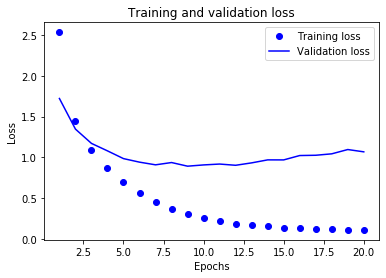

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline

loss, val_loss= history.history["loss"], history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 7. (과대적합 되기 전까지) 모델 학습 

In [94]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 2s 276us/step - loss: 2.5398 - acc: 0.5226 - val_loss: 1.6733 - val_acc: 0.6570
Epoch 2/9
7982/7982 [==============================] - 1s 101us/step - loss: 1.3712 - acc: 0.7121 - val_loss: 1.2758 - val_acc: 0.7210
Epoch 3/9
7982/7982 [==============================] - 1s 99us/step - loss: 1.0136 - acc: 0.7781 - val_loss: 1.1303 - val_acc: 0.7530
Epoch 4/9
7982/7982 [==============================] - 1s 104us/step - loss: 0.7976 - acc: 0.8251 - val_loss: 1.0539 - val_acc: 0.7590
Epoch 5/9
7982/7982 [==============================] - 1s 97us/step - loss: 0.6393 - acc: 0.8624 - val_loss: 0.9754 - val_acc: 0.7920
Epoch 6/9
7982/7982 [==============================] - 1s 97us/step - loss: 0.5124 - acc: 0.8921 - val_loss: 0.9102 - val_acc: 0.8140
Epoch 7/9
7982/7982 [==============================] - 1s 96us/step - loss: 0.4124 - acc: 0.9137 - val_loss: 0.8932 - val_acc: 0.8210
Epoch 8/9
7

## 8. 학습된 모델로 새로운 데이터 예측

In [96]:
predictions = model.predict(x_test)

In [97]:
predictions[0].shape 

(46,)

In [98]:
np.sum(predictions[0]) # 0번째 문장의 확률 합이 1

1.0

In [100]:
np.argmax(predictions[0])

3

##  sparse_categorical_crossentropy

In [68]:
# 개발자가 라벨을 원핫인코딩 안해도 케라스가 알아서 원핫인코딩해서 출력함. 
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
# 원핫인코딩 여러 개를 인덱싱을 통해 1차원 벡터로 만듦. 


## 큰 층을 두어야 하는 이유

In [107]:
model = models.Sequential()
#10000차원의 벡터를 첫 레이어에서 64차원으로 학습함.  
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
# 64를 다시 4차원으로 줄임
# 4개의 특징, 4차원의 표현으로 46개의 카테고리를 분류해야 하기 때문에 한계가 있다. 과도한 정보손실 같음.
model.add(layers.Dense(4, activation='relu')) # 이런 층을 bottlenet층이라고 함

model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 174us/step - loss: 3.2637 - acc: 0.1164 - val_loss: 2.6037 - val_acc: 0.4360
Epoch 2/20
7982/7982 [==============================] - 1s 122us/step - loss: 2.0277 - acc: 0.5372 - val_loss: 1.7440 - val_acc: 0.6150
Epoch 3/20
7982/7982 [==============================] - 1s 123us/step - loss: 1.5103 - acc: 0.6198 - val_loss: 1.5876 - val_acc: 0.5920
Epoch 4/20
7982/7982 [==============================] - 1s 122us/step - loss: 1.3410 - acc: 0.6470 - val_loss: 1.4951 - val_acc: 0.6390
Epoch 5/20
7982/7982 [==============================] - 1s 121us/step - loss: 1.2258 - acc: 0.6951 - val_loss: 1.4542 - val_acc: 0.6570
Epoch 6/20
7982/7982 [==============================] - 1s 123us/step - loss: 1.1367 - acc: 0.7145 - val_loss: 1.4226 - val_acc: 0.6680
Epoch 7/20
7982/7982 [==============================] - 1s 121us/step - loss: 1.0686 - acc: 0.7241 - val_loss: 1.4224 - val_acc: 0.6780


# 모델 학습 (조기 종료 콜백함수 버전 )

In [64]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
# earlystopping: 멈추는 조건 설정
## val_loss를 모니터링할 것(이를 기준으로 콜백). 
## 검증셋 로스가 최저점 찍더라도 다시 오르내릴 수 있으니까 3에폭 더 해보고 계속 올라가면 멈춤
# modelcheckpoint: earlystopping의 결과를 파일로 저장
## 파일패스는 상대주소로(현재 실행중인 주피터파일 주소)
## 동일하게 val_loss 기준으로 베스트만 저장
callbacks_list = [EarlyStopping(monitor='val_loss', patience=4),
                  ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True)]

history = model.fit(X_train, 
                    y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(X_valid, y_valid),
                    callbacks = callbacks_list)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 4s 240us/step - loss: 0.4626 - acc: 0.8152 - val_loss: 0.3352 - val_acc: 0.8770
Epoch 2/20
15000/15000 [==============================] - 2s 143us/step - loss: 0.2552 - acc: 0.9133 - val_loss: 0.2787 - val_acc: 0.8894
Epoch 3/20
15000/15000 [==============================] - 2s 144us/step - loss: 0.1818 - acc: 0.9374 - val_loss: 0.2743 - val_acc: 0.8902
Epoch 4/20
15000/15000 [==============================] - 2s 147us/step - loss: 0.1425 - acc: 0.9507 - val_loss: 0.2888 - val_acc: 0.8876
Epoch 5/20
15000/15000 [==============================] - 2s 146us/step - loss: 0.1127 - acc: 0.9629 - val_loss: 0.3111 - val_acc: 0.8846
Epoch 6/20
15000/15000 [==============================] - 2s 145us/step - loss: 0.0887 - acc: 0.9715 - val_loss: 0.3683 - val_acc: 0.8736
Epoch 7/20
15000/15000 [==============================] - 2s 145us/step - loss: 0.0706 - acc: 0.9776 - val_loss: 0.3787 - 

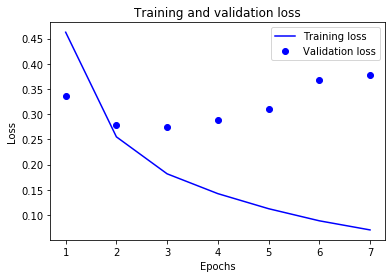

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss') # 'b'는 파란색 실선을 의미
plt.plot(epochs, val_loss, 'bo', label='Validation loss') # 'bo'는 파란색 점을 의미
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()

plt.show()

In [66]:
from keras.models import load_model

model = load_model('model.h5')
print('>> model load!!')


>> model load!!


In [67]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test loss: ', test_loss)
print('test acc: ', test_acc)

25000/25000 [==============================] - 3s 138us/step
test loss:  0.2916898069572449
test acc:  0.8814
